In [1]:
from src.classes.network import Network
from src.classes.node import Node
from src.classes.network import Network
from src.viusalization import plot_network
from src.viusalization import print_network

%matplotlib notebook
%matplotlib inline

between frames 0, 50 there were 12 alterations made
between frames 0, 50 there were 22 alterations made
between frames 50, 100 there were 4 alterations made
between frames 100, 150 there were 0 alterations made
between frames 150, 200 there were 0 alterations made
between frames 200, 250 there were 0 alterations made
between frames 250, 300 there were 0 alterations made
between frames 300, 350 there were 0 alterations made
between frames 350, 400 there were 1 alterations made
between frames 400, 450 there were 0 alterations made
between frames 450, 500 there were 0 alterations made
between frames 500, 550 there were 0 alterations made
between frames 550, 600 there were 0 alterations made
between frames 600, 650 there were 1 alterations made


KeyboardInterrupt: 

between frames 0, 50 there were 0 alterations made


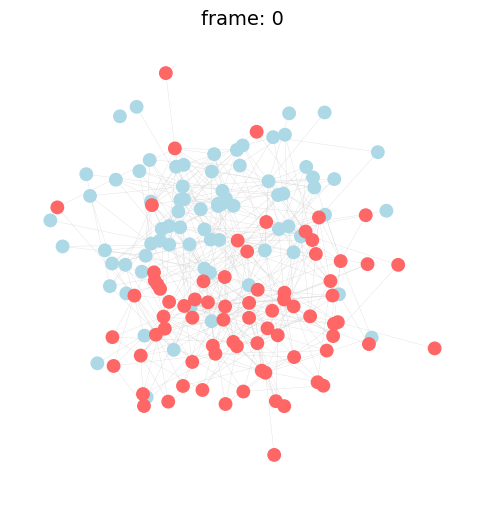

In [ ]:
# voorbeeld

num_nodes = 150
correlation = -1
update_fraction = 0.2
starting_distribution = 0.5     # L / R ratio (niet per se nodig maar kan misschien leuk zijn om te varieern)
p = 0.02
k = 2

network = Network(num_nodes, 0, correlation, starting_distribution, update_fraction, p, k=2)

# for round in range(100):
#     network.update_round()

# def create_network():
# netwerkje = Network(100, -1, p=0.02)

animation = plot_network(network)


{<src.classes.node.Node object at 0x0000024AECDD7750>, <src.classes.node.Node object at 0x0000024AECDD4ED0>, <src.classes.node.Node object at 0x0000024AECDD55D0>, <src.classes.node.Node object at 0x0000024AECDD5E10>, <src.classes.node.Node object at 0x0000024AECDD5310>, <src.classes.node.Node object at 0x0000024AECDD5010>, <src.classes.node.Node object at 0x0000024AEDC2EA10>, <src.classes.node.Node object at 0x0000024AECDD5F90>, <src.classes.node.Node object at 0x0000024AECDD6650>, <src.classes.node.Node object at 0x0000024AECDD57D0>, <src.classes.node.Node object at 0x0000024AECDD5690>, <src.classes.node.Node object at 0x0000024AEDC2F050>, <src.classes.node.Node object at 0x0000024AECDD5850>, <src.classes.node.Node object at 0x0000024AECDD5350>, <src.classes.node.Node object at 0x0000024AECDD5050>, <src.classes.node.Node object at 0x0000024AECDD4F10>, <src.classes.node.Node object at 0x0000024AECDD4C50>, <src.classes.node.Node object at 0x0000024AECDD4890>, <src.classes.node.Node obje

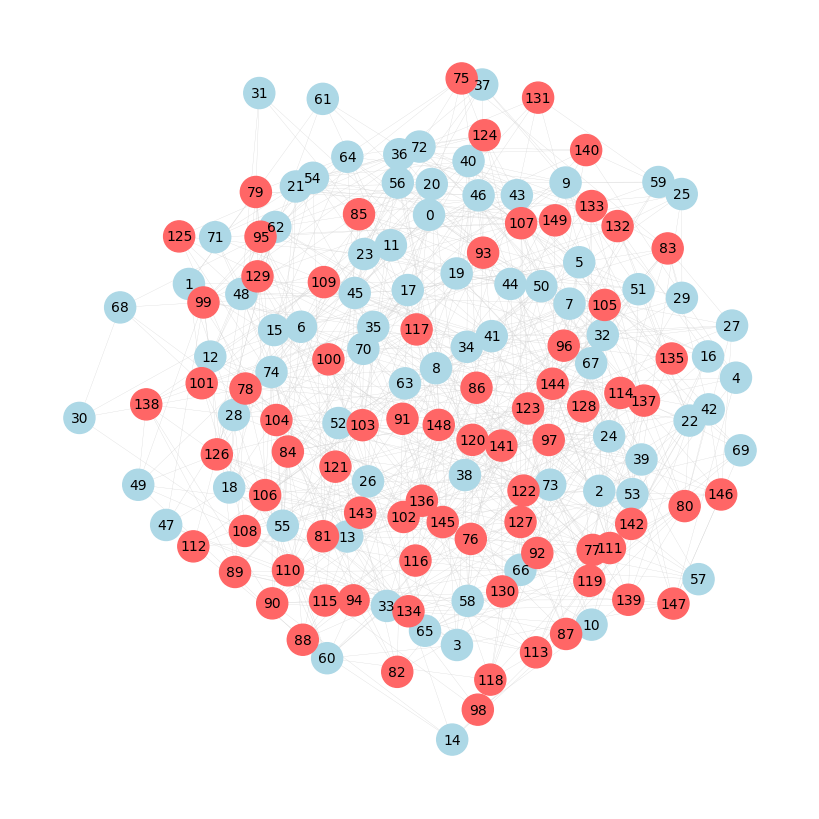

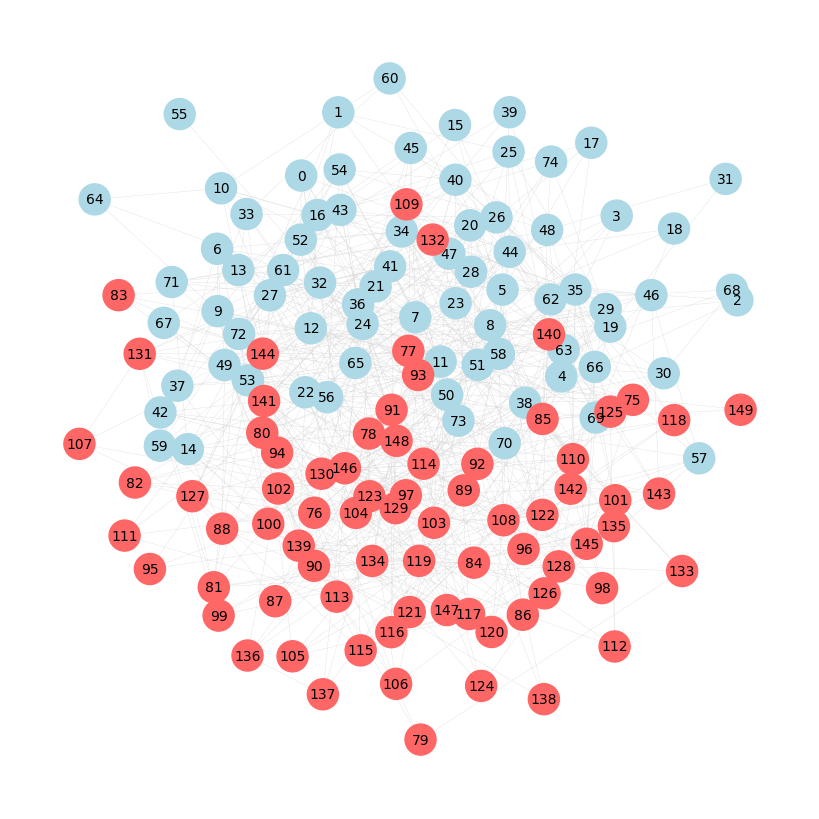

In [7]:
network = Network(num_nodes, 0, correlation, starting_distribution, update_fraction, p, k=2)
for i in range(100000):
    if i ==0:
        print_network(network)
    network.update_round()

print_network(network)
    # print(network.alterations)


In [18]:
for i in network.nodesR:
    if i.ID == 134:
        print(i.response_threshold)

0.4562975568101405
